In [1]:
import numpy as np
import pandas as pd

# Read the CSV file using ISO-8859-1 encoding
raw_dataset = pd.read_csv('Modified_SQL_Dataset.csv', encoding='ISO-8859-1')

# Display information about the dataset
raw_dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30919 entries, 0 to 30918
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Query   30919 non-null  object
 1   Label   30919 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 483.2+ KB


There are no null/missing values in the dataset.  
We have two columns:
1. **Query**: SQL query
2. **Label**: 1 if injection 0 otherwise

In [2]:
raw_dataset.head()

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


In [3]:
raw_dataset.tail()

,Query,Label
30914,DELETE FROM door WHERE grow = 'small',0
30915,DELETE FROM tomorrow,0
30916,SELECT wide ( s ) FROM west,0
30917,SELECT * FROM ( SELECT slide FROM breath ),0
30918,SELECT TOP 3 * FROM race,0


In [4]:
raw_dataset.isnull().sum()

Query    0
Label    0
dtype: int64

In [5]:
raw_dataset.isna().sum()

Query    0
Label    0
dtype: int64

<Axes: xlabel='Label'>

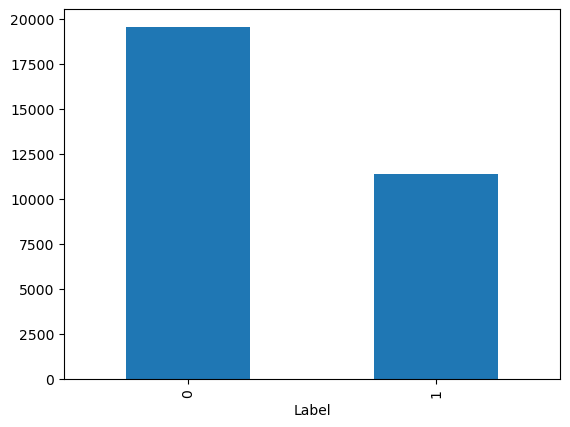

In [6]:
raw_dataset['Label'].value_counts().plot(kind='bar')

**Positive class** - 11382  
**Negative class** - 19537  
Dataset is imbalanced with popsitive to negative class ratio of 37:63 (~ 4:7)

### Duplicate removal

In [7]:
raw_dataset[raw_dataset.duplicated(keep=False)].sort_values(by=['Query'])

,Query,Label
656,#NAME?,1
866,#NAME?,1
15635,#NAME?,0
17913,#NAME?,0
13532,#NAME?,0
...,...,...
13214,9.55E+15,0
13355,9.77E+15,0
16946,9.77E+15,0
17760,9.83E+15,0


* Here we have found 20 duplicate values.
* All values looks like number and not like SQL query.
* Let us remove all the datapoints.

In [8]:
raw_dataset.drop_duplicates(keep=False, inplace=True)

In [9]:
raw_dataset.shape

(30632, 2)

## Data Cleaning

We have so many white spaces in the queries and multiple special characters.  
We can try to train model by removing the special characters.  
If this does not work, we can include special characters afterwards.  
Let's create two datasets one with and other without special characters.  
This all are SQL queries so no need to remove stop words.

In [10]:
import re

In [11]:
sample_query = raw_dataset['Query'][9780]
sample_query

"1'||  (  select 'rjis' from dual where 7696  =  7696 and 3754  =    (  select upper  (  xmltype  (  chr  (  60  )  ||chr  (  58  )  ||chr  (  113  )  ||chr  (  113  )  ||chr  (  112  )  ||chr  (  106  )  ||chr  (  113  )  ||  (  select   (  case when   (  3754  =  3754  )   then 1 else 0 end  )   from dual  )  ||chr  (  113  )  ||chr  (  122  )  ||chr  (  118  )  ||chr  (  122  )  ||chr  (  113  )  ||chr  (  62   )    )     )   from dual   )    )   ||'"

In [12]:
def remove_spaces(input_string):
    cleaned = re.sub('\s{2,}',' ',input_string)
    return cleaned.lower().strip()

print(remove_spaces(sample_query))

1'|| ( select 'rjis' from dual where 7696 = 7696 and 3754 = ( select upper ( xmltype ( chr ( 60 ) ||chr ( 58 ) ||chr ( 113 ) ||chr ( 113 ) ||chr ( 112 ) ||chr ( 106 ) ||chr ( 113 ) || ( select ( case when ( 3754 = 3754 ) then 1 else 0 end ) from dual ) ||chr ( 113 ) ||chr ( 122 ) ||chr ( 118 ) ||chr ( 122 ) ||chr ( 113 ) ||chr ( 62 ) ) ) from dual ) ) ||'


In [13]:
def clean_all(input_string):
    cleaned = re.sub('[^a-zA-Z0-9\s]',' ',input_string)
    cleaned = re.sub('\s{2,}',' ',cleaned)
    return cleaned.lower().strip()
print(clean_all(sample_query))

1 select rjis from dual where 7696 7696 and 3754 select upper xmltype chr 60 chr 58 chr 113 chr 113 chr 112 chr 106 chr 113 select case when 3754 3754 then 1 else 0 end from dual chr 113 chr 122 chr 118 chr 122 chr 113 chr 62 from dual


In [14]:
dataset_with_special_characters = raw_dataset.copy()
dataset_with_special_characters['Query'] = dataset_with_special_characters['Query'].apply(remove_spaces)
dataset_with_special_characters.head()

,Query,Label
0,""" or pg_sleep ( __time__ ) --",1
1,create user name identified by pass123 tempora...,1
2,and 1 = utl_inaddr.get_host_address ( ( select...,1
3,select * from users where id = '1' or @ @1 = 1...,1
4,"select * from users where id = 1 or 1#"" ( unio...",1


In [15]:
dataset_all_cleaned = raw_dataset.copy()
dataset_all_cleaned['Query'] = dataset_all_cleaned['Query'].apply(clean_all)
dataset_all_cleaned.head()

,Query,Label
0,or pg sleep time,1
1,create user name identified by pass123 tempora...,1
2,and 1 utl inaddr get host address select disti...,1
3,select from users where id 1 or 1 1 union sele...,1
4,select from users where id 1 or 1 union select...,1


Let us see if we have any duplicates after removing special characters.

In [16]:
dataset_all_cleaned[dataset_all_cleaned.duplicated(keep=False)].sort_values(by='Query')

,Query,Label
863,,1
535,,1
856,,1
282,,1
402,,1
...,...,...
756,x and members email is null,1
464,x and userid is null,1
362,x and userid is null,1
865,x or full name like bob,1


In [17]:
dataset_all_cleaned.drop_duplicates(keep='first', inplace=True)
dataset_all_cleaned.shape

(27873, 2)

**Special Characters Count**  
Let's find out if number of special characters in the query has any relation with dependent variable.

In [18]:
no_of_special_chars = raw_dataset['Query'].map(lambda x:len(re.findall('[^a-zA-Z0-9\s]',x)))
no_of_special_chars.describe()

count    30632.000000
mean         8.027520
std         12.393144
min          0.000000
25%          1.000000
50%          4.000000
75%         10.000000
max        601.000000
Name: Query, dtype: float64

D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


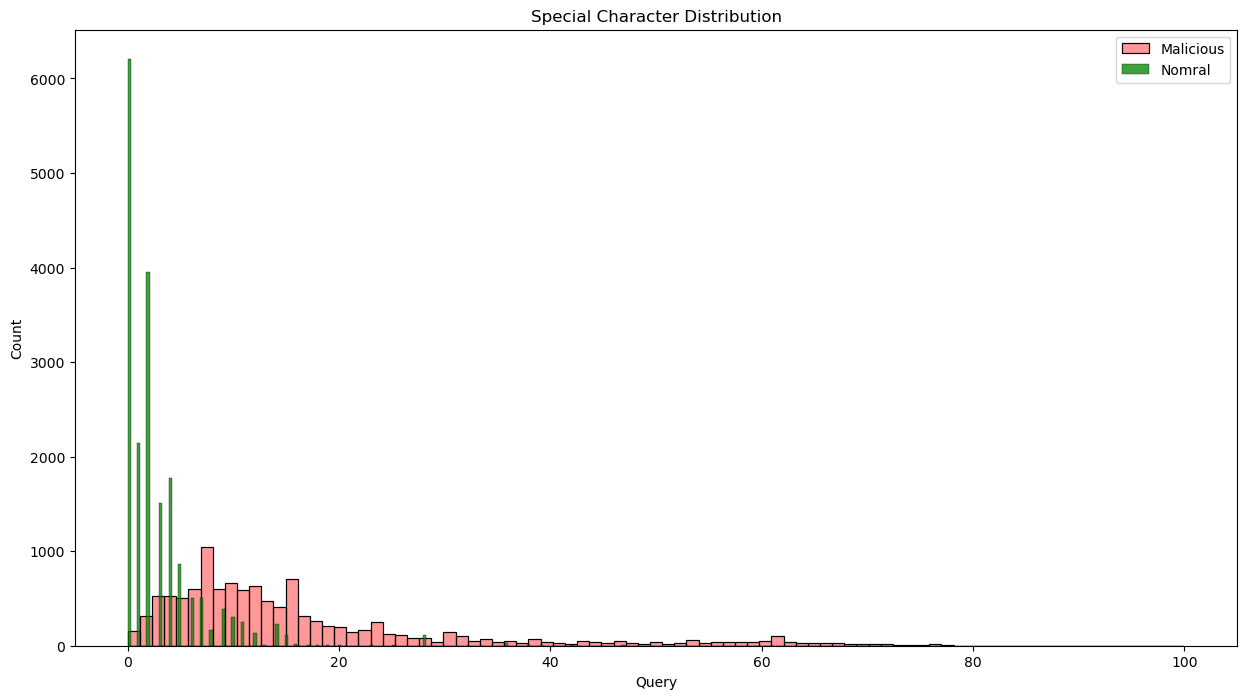

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns
fig3, ax_sc = plt.subplots(1, 1, figsize=(15,8))
sns.histplot(no_of_special_chars[raw_dataset['Label']==1], ax=ax_sc, color='red', label='Malicious', binrange=(0,100) ,alpha=0.4)
sns.histplot(no_of_special_chars[raw_dataset['Label']==0], ax=ax_sc, color='green', label='Nomral', binrange=(0,100))
ax_sc.set_title("Special Character Distribution")
ax_sc.legend()

**NOTE**: Here we can see, Number of special characters in a query has almost sane distribution for normal and malicious queries. This is not a good feature to make classification.

Let's remove the duplicates and keep the first instance only.

In [20]:
query_length = dataset_all_cleaned.Query.map(lambda x:len(x.split()))
query_length.describe()

count    27873.000000
mean         9.063969
std          9.272374
min          0.000000
25%          3.000000
50%          7.000000
75%         11.000000
max        542.000000
Name: Query, dtype: float64

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

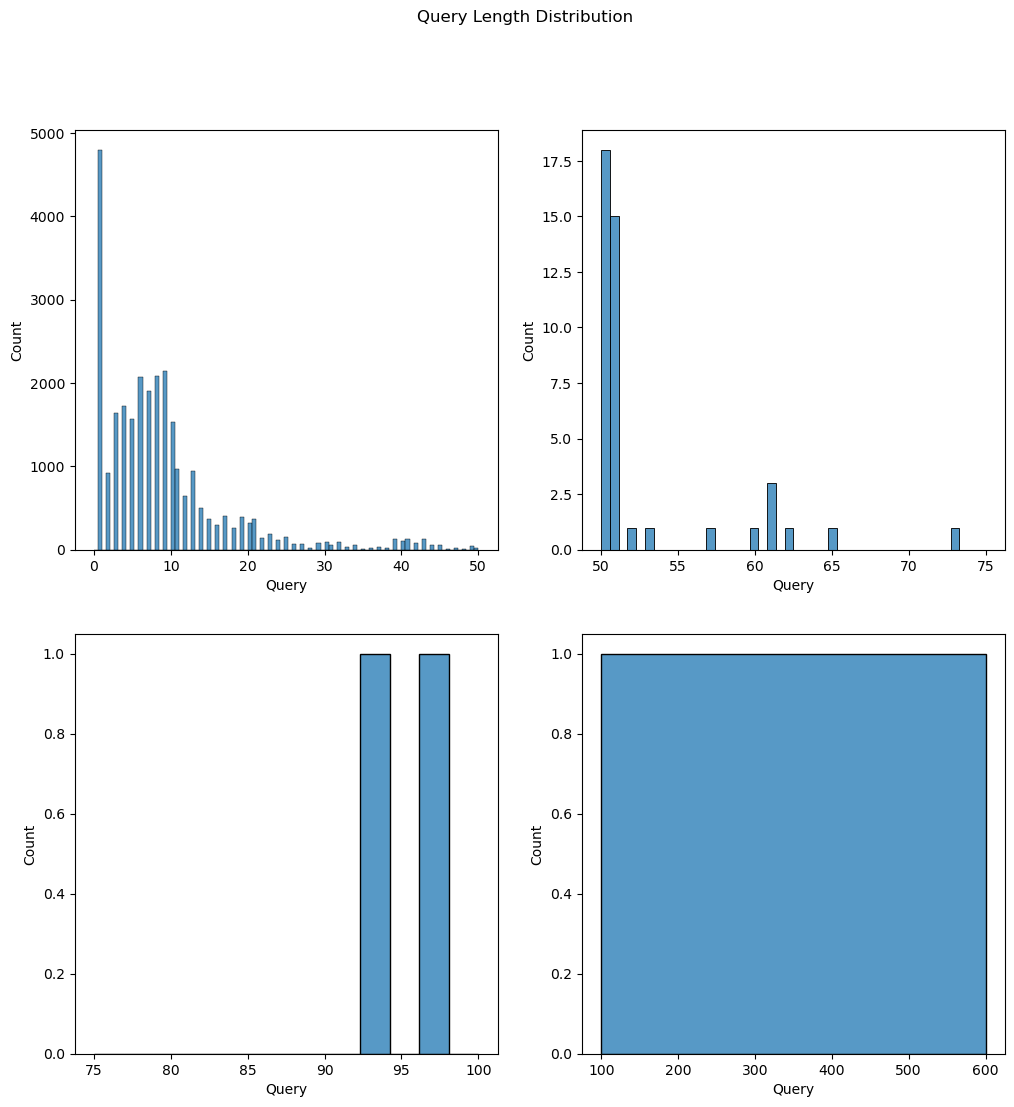

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))
sns.histplot(query_length, binrange=(0,50), ax=ax1)
sns.histplot(query_length, binrange=(50,75), ax=ax2)
sns.histplot(query_length, binrange=(75,100), ax=ax3)
sns.histplot(query_length, binrange=(100,600), ax=ax4)
plt.suptitle("Query Length Distribution");

In [23]:
print("0 words   =", (query_length==0).value_counts()[True])
print("1 words   =", (query_length==1).value_counts()[True])
print("2 words   =", (query_length==2).value_counts()[True])
print("Less than 5 words   =", (query_length<5).value_counts()[True])
print("Less than 10 words  =", (query_length<10).value_counts()[True])
print("Less than 15 words  =", (query_length<15).value_counts()[True])
print("Less than 50 words  =", (query_length<50).value_counts()[True])
print("More than 90 words =", (query_length>90).value_counts()[True])
print("More than 500 words =", (query_length>500).value_counts()[True])

0 words   = 1
1 words   = 4797
2 words   = 918
Less than 5 words   = 9075
Less than 10 words  = 18843
Less than 15 words  = 23424
Less than 50 words  = 27827
More than 90 words = 3
More than 500 words = 1


Here we have one outlier where we do not have any query.
We need to find that and remove from dataset.

In [24]:
for per in range(10,101,10):
    print(f'{per} percentile for query length = {np.percentile(query_length, per)}')
print('-'*40)
for per in range(91,101,1):
    print(f'{per} percentile for query length = {np.percentile(query_length, per)}')
print('-'*40)
for per in np.linspace(99,100,11):
    print(f'{per} percentile for query length = {np.percentile(query_length, per)}')

10 percentile for query length = 1.0
20 percentile for query length = 2.0
30 percentile for query length = 4.0
40 percentile for query length = 6.0
50 percentile for query length = 7.0
60 percentile for query length = 9.0
70 percentile for query length = 10.0
80 percentile for query length = 13.0
90 percentile for query length = 19.0
100 percentile for query length = 542.0
----------------------------------------
91 percentile for query length = 20.0
92 percentile for query length = 21.0
93 percentile for query length = 22.0
94 percentile for query length = 24.0
95 percentile for query length = 26.0
96 percentile for query length = 30.0
97 percentile for query length = 37.0
98 percentile for query length = 40.0
99 percentile for query length = 43.0
100 percentile for query length = 542.0
----------------------------------------
99.0 percentile for query length = 43.0
99.1 percentile for query length = 43.0
99.2 percentile for query length = 44.0
99.3 percentile for query length = 44.0


**Observations**  
From histogram, percentiles and other observations for query length:
1. 90% of the queries are having 19 or less words.
2. 95% of the queries are having 26 or less words.
3. Less than 1% of the data have more than 43 words.
4. Only one outlier query has 542 words.
5. Only one outlier query has 0 words (only space).

**Outlier Removal**  
Let's remove query with length 0(minimum) and 542(maximum).

In [25]:
dataset_all_cleaned[dataset_all_cleaned['Query'].map(lambda x:len(x.split()))==0]

,Query,Label
208,,1


In [26]:
dataset_all_cleaned[dataset_all_cleaned['Query'].map(lambda x:len(x.split()))==542]

,Query,Label
19341,de email address find account answer cdata fqa...,0


In [27]:
# with pd.option_context('display.max_colwidth', None):
long_query=dataset_all_cleaned[dataset_all_cleaned['Query'].map(lambda x:len(x.split()))==542]['Query'].item()
print(long_query)

de email address find account answer cdata fqaepqdkct find account answer find account question cdata 6 find account question homepage cdata homepage is secret cdata is secret methodcall mid cdata qna mid module cdata member module nick name cdata elwoodbuckley041104 nick name params password2 cdata yxg6dsf5iu password2 password cdata yxg6dsf5iu password reward point cdata 0 reward point title cdata ways to make cash online make money from home title user id cdata elwoodbuckley041104 user id user name cdata elwoodbuckley041104 user name 01 7520 a3b10 a3b12c41 a3b12c411 app ar 203 ascd agahmzm3msdfjmwmexg6pvz1i3dhgd7dst5ve9qu n91bdfdeb5ebdeo m5lphloo5yon zys1jabrmzu2wuhosclewjjadz2yhm9tjwbluelc jm8eix vtywmmo5osa8fbyznpanaxi7ty0n7avqytu2rek2f n c390zlvthtsxl1isk49osewueazdarlmluwcpx6xsdjfz 1cgweoailj9q5nobm6nyipbgovj6yzgiencnt9gu6x6sgknppx0ygxxmss 0qi5exwmdn30ulwjftbmc ta17xldxgm6f him7f4fde 5c pavn9eizxye9k6g gycm7i0dzjpisjeowl96y fyxozojcp79klwtty6f1dl1has8dsfoirfous7zyftzgmnv2k0st68i

**Above two data points are surely noisy and we can remove them.**

In [28]:
dataset_all_cleaned.drop([208,19341], inplace=True)
dataset_all_cleaned.shape

(27871, 2)

Now let us check query length distribution for both classes.

In [29]:
normal_queries = dataset_all_cleaned[dataset_all_cleaned['Label']==0]
malicious_queries = dataset_all_cleaned[dataset_all_cleaned['Label']==1]

In [30]:
normal_queries_length = normal_queries.Query.map(lambda x:len(x.split()))
malicious_queries_length = malicious_queries.Query.map(lambda x:len(x.split()))

D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

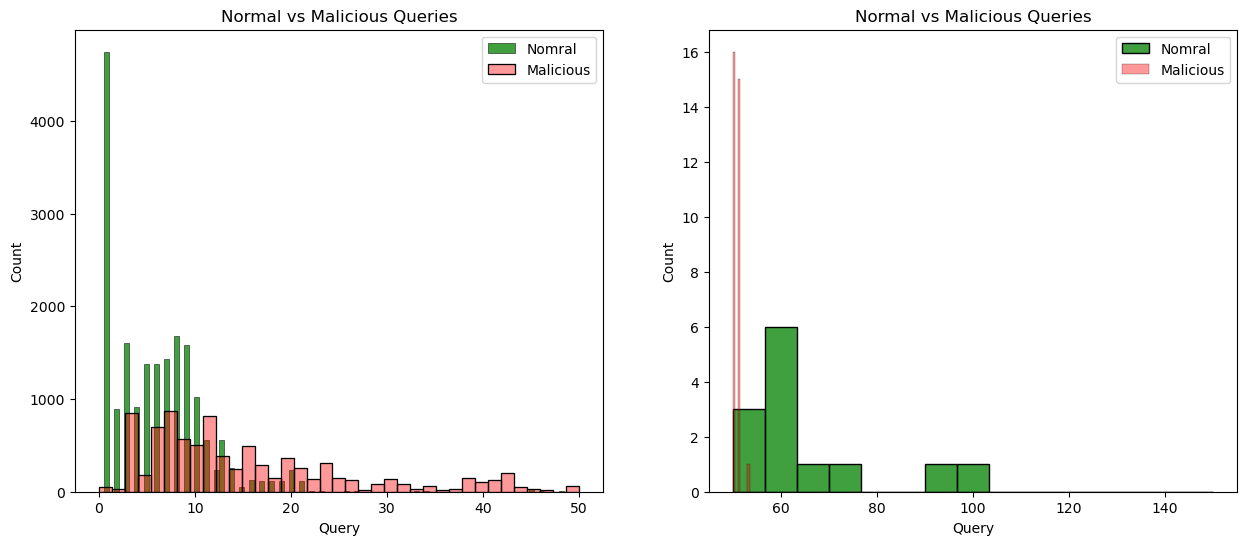

In [31]:
fig2, ((ax21, ax22)) = plt.subplots(1, 2, figsize=(15,6))
sns.histplot(normal_queries_length, binrange=(0,50), ax=ax21, color='green', label='Nomral')
sns.histplot(normal_queries_length, binrange=(50,150), ax=ax22, color='green', label='Nomral')
sns.histplot(malicious_queries_length, binrange=(0,50), ax=ax21, color='red', label='Malicious', alpha=0.4)
sns.histplot(malicious_queries_length, binrange=(50,150), ax=ax22, color='red', label='Malicious', alpha=0.4)
ax21.set_title("Normal vs Malicious Queries")
ax22.set_title("Normal vs Malicious Queries")
ax21.legend()
ax22.legend();

**NOTE**: Query length for both classes are having almost same distribution so it won't add any value classifying dependent variable.

### Baseline model and feature selection  
Here our goal is to find out the words or series of words which are common in attacks.  
We can either use TFIDF or simple tokenization which will find out the pattern in n-gram features to identify the attack.  
**NOTE**: We will first try with all cleaned data.

In [32]:
import pickle

In [33]:
with open('dataset_all_cleaned.df', 'wb') as file:
  pickle.dump(dataset_all_cleaned, file)

In [34]:
X = dataset_all_cleaned['Query']
y = dataset_all_cleaned['Label']

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [36]:
y_train.value_counts()

Label
0    13440
1     6069
Name: count, dtype: int64

In [37]:
y_test.value_counts()

Label
0    5759
1    2603
Name: count, dtype: int64

### Tokenization
We will tokenize data using counter vectorizer and TFIDF both.

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,3), max_features=2500)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=2500)
X_train_tfidfvec = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidfvec = tfidf_vectorizer.transform(X_test)

Let us try to visualize data in 2D using TSNE

### Random Forest Model
1. Using count vectorized data

In [40]:
from sklearn.ensemble import RandomForestClassifier

RFC_model = RandomForestClassifier()
RFC_model.fit(X_train_vec, y_train)
RFC_model.score(X_test_vec, y_test)

0.996412341545085

2. Using TFIDF vectorized data

In [41]:
RFC_model_tfidf = RandomForestClassifier()
RFC_model_tfidf.fit(X_train_tfidfvec, y_train)
RFC_model_tfidf.score(X_test_tfidfvec, y_test)

0.9956948098541019

In [42]:
RFC_model_y_pred = RFC_model.predict(X_test_vec)
RFC_model_tfidf_y_pred = RFC_model_tfidf.predict(X_test_tfidfvec)

Confusion matrix

In [43]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

F1 Score for simple model :  99.42 %


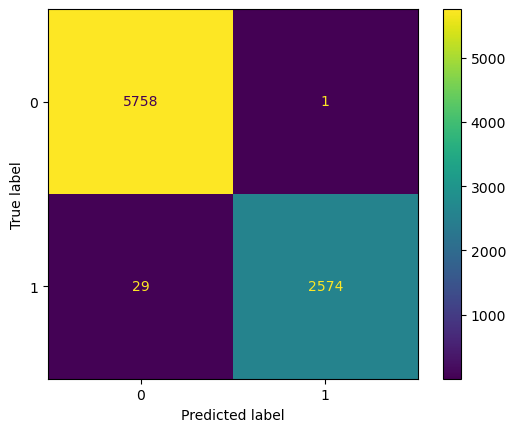

In [44]:
print("F1 Score for simple model : ", round(f1_score(y_test, RFC_model_y_pred)*100,2),"%")
cm_1 = ConfusionMatrixDisplay(confusion_matrix(y_test, RFC_model_y_pred))
cm_1.plot()

F1 Score for TFIDF model :  99.3 %


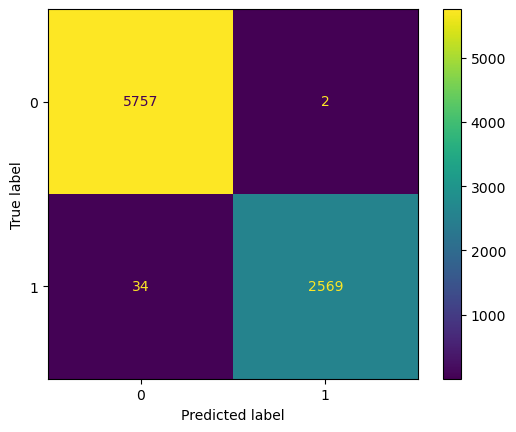

In [45]:
print("F1 Score for TFIDF model : ", round(f1_score(y_test, RFC_model_tfidf_y_pred)*100,2),"%")
cm_2 = ConfusionMatrixDisplay(confusion_matrix(y_test, RFC_model_tfidf_y_pred))
cm_2.plot()

roc_auc =  99.43


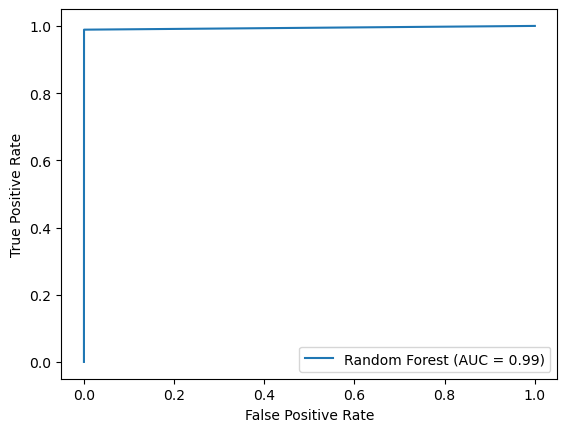

In [46]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, RFC_model_y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest')
display.plot()
print("roc_auc = ", round(roc_auc*100,2))

roc_auc =  99.33


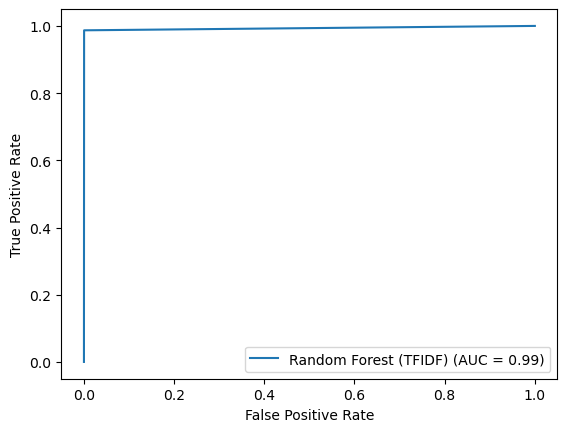

In [47]:
fpr, tpr, thresholds = roc_curve(y_test, RFC_model_tfidf_y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest (TFIDF)')
display.plot()
print("roc_auc = ", round(roc_auc*100,2))

In [48]:
from sklearn.model_selection import cross_val_score, cross_validate
cross_val_score(RFC_model, X_train_vec, y_train, cv=5, scoring='f1')

array([0.99462143, 0.99462588, 0.99295483, 0.99421488, 0.993372  ])

In [49]:
cross_validate(RFC_model, X_train_vec, y_train, cv=3, scoring='f1', n_jobs=-1)

{'fit_time': array([2.40706325, 2.19828248, 2.12432742]),
 'score_time': array([0.1592958 , 0.17384887, 0.18428445]),
 'test_score': array([0.99429705, 0.99328525, 0.99304866])}

<Axes: >

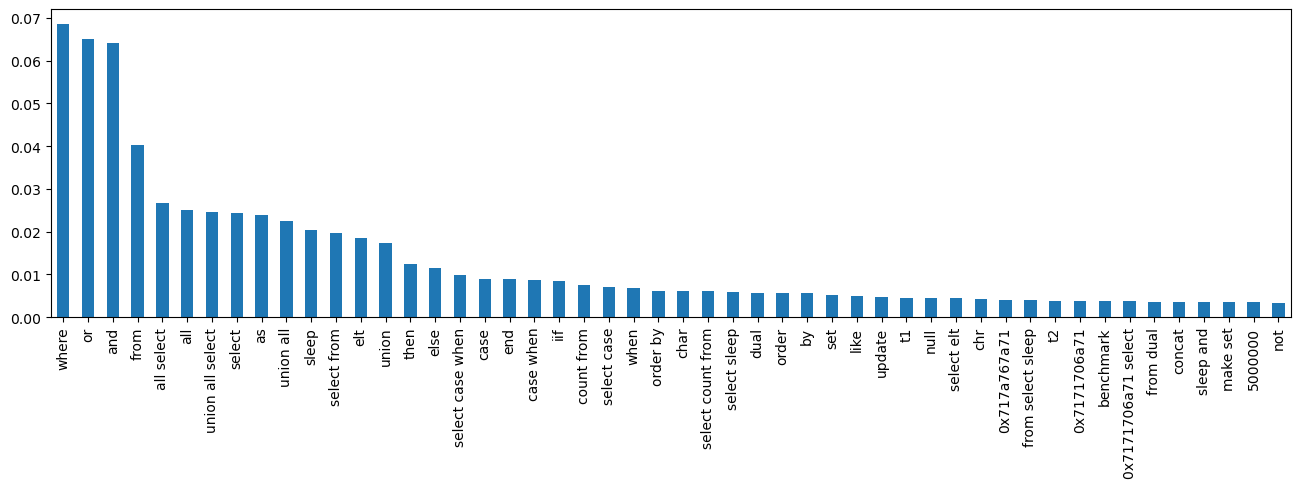

In [50]:
importances = RFC_model.feature_importances_
forest_importances = pd.Series(importances, index=vectorizer.get_feature_names_out())
forest_importances.sort_values(inplace=True, ascending=False)
forest_importances[:50].plot(kind='bar', figsize=(16,4))

In [51]:
cross_validate(RFC_model_tfidf, X_train_tfidfvec, y_train, cv=3, scoring='f1', n_jobs=-1)

{'fit_time': array([5.06151223, 4.7159152 , 4.52712154]),
 'score_time': array([0.43086815, 0.45677352, 0.44076633]),
 'test_score': array([0.99354839, 0.99254102, 0.99303483])}

<Axes: >

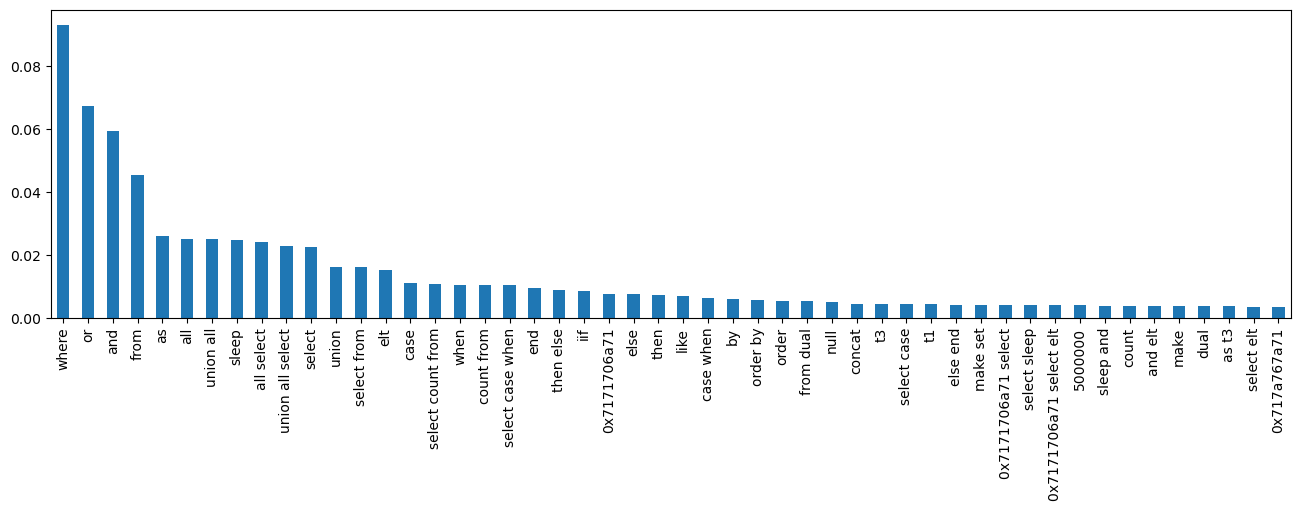

In [52]:
importances = RFC_model_tfidf.feature_importances_
forest_importances = pd.Series(importances, index=tfidf_vectorizer.get_feature_names_out())
forest_importances.sort_values(inplace=True, ascending=False)
forest_importances[:50].plot(kind='bar', figsize=(16,4))

#### Observations
1. We are getting really good accuracy and f1-score for both normal vectorizer and TFIDF vectorizer.  
2. We have currently used only words **without any special characters**.  
  
Let's try to train Random Forest model on the data **with special characters** for TFIDF vectorizer.

In [53]:
dataset_with_special_characters.shape

(30632, 2)

In [54]:
dataset_with_special_characters[dataset_with_special_characters.duplicated(keep='first')]

,Query,Label
113,or 1 = 1 or '' = ',1
130,"or 0 = 0 #""",1
150,or 'unusual' = 'unusual',1
233,or true--,1
274,select * from information_schema.tables--,1
...,...,...
20328,"select customername as customer, contactname a...",0
20329,"select customername, address + ', ' + postalco...",0
20330,"select customername, concat ( address,', ',pos...",0
20336,"select customers.customername, orders.orderid ...",0


In [55]:
dataset_with_special_characters.drop_duplicates(keep='first', inplace=True)

In [56]:
X_schar = dataset_with_special_characters['Query']
y_schar = dataset_with_special_characters['Label']

In [57]:
X_train_schar, X_test_schar, y_train_schar, y_test_schar = train_test_split(X_schar, y_schar, test_size=0.30, random_state=42)

In [58]:
tfidf_vectorizer_schar = TfidfVectorizer(ngram_range=(1,3), max_features=2500)
X_train_tfidfvec_schar = tfidf_vectorizer_schar.fit_transform(X_train_schar)
X_test_tfidfvec_schar = tfidf_vectorizer_schar.transform(X_test_schar)

In [59]:
RFC_model_tfidf_schar = RandomForestClassifier()
RFC_model_tfidf_schar.fit(X_train_tfidfvec_schar, y_train_schar)
RFC_model_tfidf_schar.score(X_test_tfidfvec_schar, y_test_schar)

0.9948712352684417

F1 Score for simple model :  99.31 %


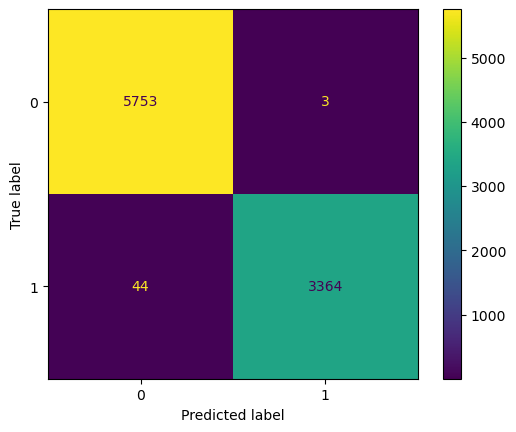

In [60]:
RFC_model_tfidf_y_pred_schar = RFC_model_tfidf_schar.predict(X_test_tfidfvec_schar)
print("F1 Score for simple model : ", round(f1_score(y_test_schar, RFC_model_tfidf_y_pred_schar)*100,2),"%")
cm_1 = ConfusionMatrixDisplay(confusion_matrix(y_test_schar, RFC_model_tfidf_y_pred_schar))
cm_1.plot()

**NOTE**: Here we can see that model is making more errors for type-1 while special characters are included.

In [61]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(estimator=RFC_model_tfidf_schar,param_grid={'n_estimators': [10, 100, 500], 'oob_score': (True, False)}, n_jobs=-1, scoring='f1')

In [62]:
clf.fit(X_train_tfidfvec_schar, y_train_schar)

D:\anaconda\Lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [10, 100, 500],
                         'oob_score': (True, False)},
             scoring='f1')

In [63]:
cv_results = pd.DataFrame(clf.cv_results_)
cv_results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_oob_score,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.642819,1.280720,0.053539,0.016190,10,True,"{'n_estimators': 10, 'oob_score': True}",0.993635,0.992357,0.991709,0.990428,0.993318,0.992289,0.001156,1
5,71.062460,2.619684,1.800343,0.425613,500,False,"{'n_estimators': 500, 'oob_score': False}",0.993955,0.992031,0.991066,0.990112,0.993318,0.992096,0.001411,2
2,7.293213,0.341541,0.359879,0.049593,100,True,"{'n_estimators': 100, 'oob_score': True}",0.993955,0.991714,0.991066,0.989796,0.993318,0.991970,0.001508,3
3,7.128772,0.637881,0.324237,0.027152,100,False,"{'n_estimators': 100, 'oob_score': False}",0.993635,0.991720,0.991388,0.989474,0.993318,0.991907,0.001497,4
4,74.494536,1.687280,1.834006,0.294643,500,True,"{'n_estimators': 500, 'oob_score': True}",0.993955,0.991399,0.991066,0.989474,0.993318,0.991842,0.001616,5
1,0.928576,0.140635,0.046955,0.001366,10,False,"{'n_estimators': 10, 'oob_score': False}",0.993314,0.991714,0.990750,0.990112,0.993318,0.991842,0.001308,6


In [64]:

RFC_model_tfidf_schar_bestCV = clf.best_estimator_

In [65]:
# RFC_model_tfidf_schar_bestCV.fit(X_train_tfidfvec_schar, y_train_schar)
RFC_model_tfidf_schar_bestCV.score(X_test_tfidfvec_schar, y_test_schar)

0.9947621126145788

F1 Score for simple model :  99.29 %


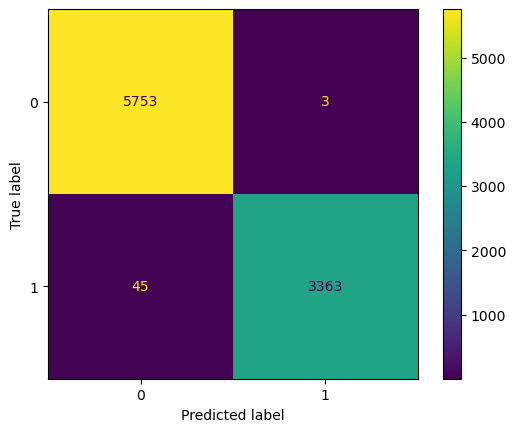

In [66]:
RFC_model_tfidf_y_pred_schar = RFC_model_tfidf_schar_bestCV.predict(X_test_tfidfvec_schar)
print("F1 Score for simple model : ", round(f1_score(y_test_schar, RFC_model_tfidf_y_pred_schar)*100,2),"%")
cm_1 = ConfusionMatrixDisplay(confusion_matrix(y_test_schar, RFC_model_tfidf_y_pred_schar))
cm_1.plot()

Even After doing hyperparameter tuning, we are not getting better score with special characters.  

## Conclusion
1. We get better results by removing special characters.
2. We get almost same result for normal count vectorizer and TFIDF vectorizer.
3. Random Forest model with default parameters works the best.

In [67]:
import pickle

In [68]:
import pickle
filename='sql.sav'
pickle.dump(RFC_model ,open('sql.sav','wb'))
loaded_model=pickle.load(open('sql.sav','rb'))